# Wine Quality Prediction — Simplified & Environment-agnostic
This notebook trains three classifiers (RandomForest, SGD, SVC) on the wine dataset.
It is intentionally short and uses minimal dependencies for clarity.

In [7]:
import os, pandas as pd
csv_path = '../data/WineQT.csv'
print('CSV exists:', os.path.exists(csv_path))
df = pd.read_csv(csv_path)
print('Loaded shape:', df.shape)
df.columns = [c.strip().lower().replace(' ','_') for c in df.columns]
df.head()

CSV exists: True
Loaded shape: (1143, 13)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [8]:
# Simple cleaning: drop duplicates and fill small missingness for numeric columns
df = df.drop_duplicates().reset_index(drop=True)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
for c in num_cols:
    pct = df[c].isnull().mean()*100
    if 0 < pct < 5:
        df[c] = df[c].fillna(df[c].median())
print('After cleaning shape:', df.shape)

After cleaning shape: (1143, 13)


In [9]:
# Prepare features and target (3-class label: low/medium/high)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
df['quality_label'] = pd.cut(df['quality'], bins=[-1,4,6,100], labels=['low','medium','high'])
X = df.select_dtypes(include=['number']).drop(columns=['quality'])
y = LabelEncoder().fit_transform(df['quality_label'].astype(str))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train/test shapes:', X_train.shape, X_test.shape)

Train/test shapes: (914, 12) (229, 12)


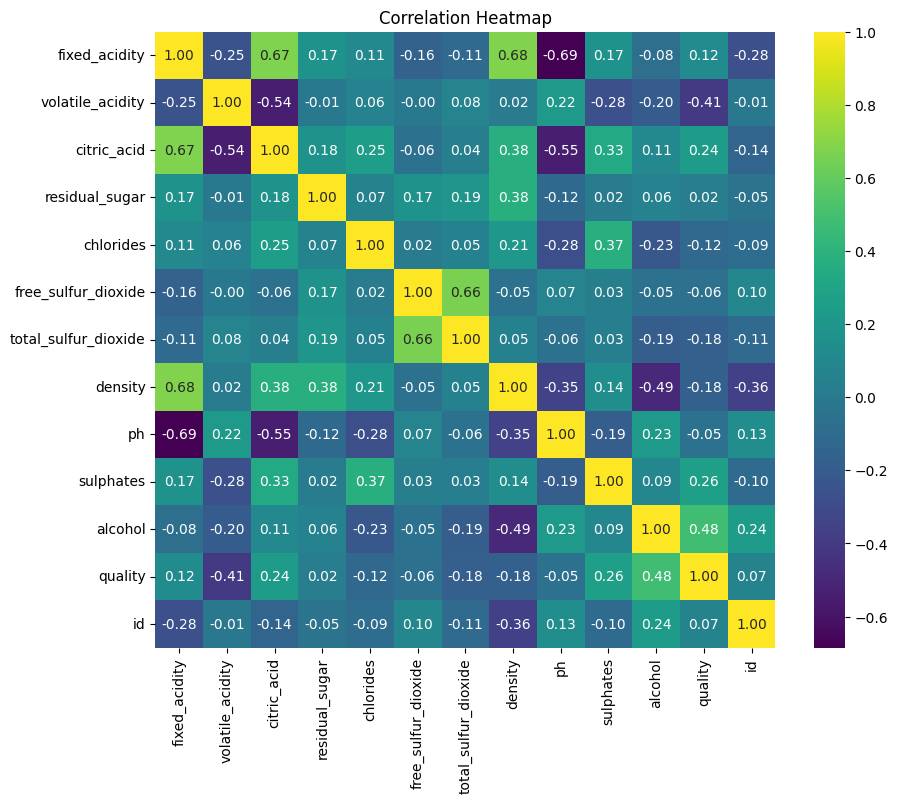

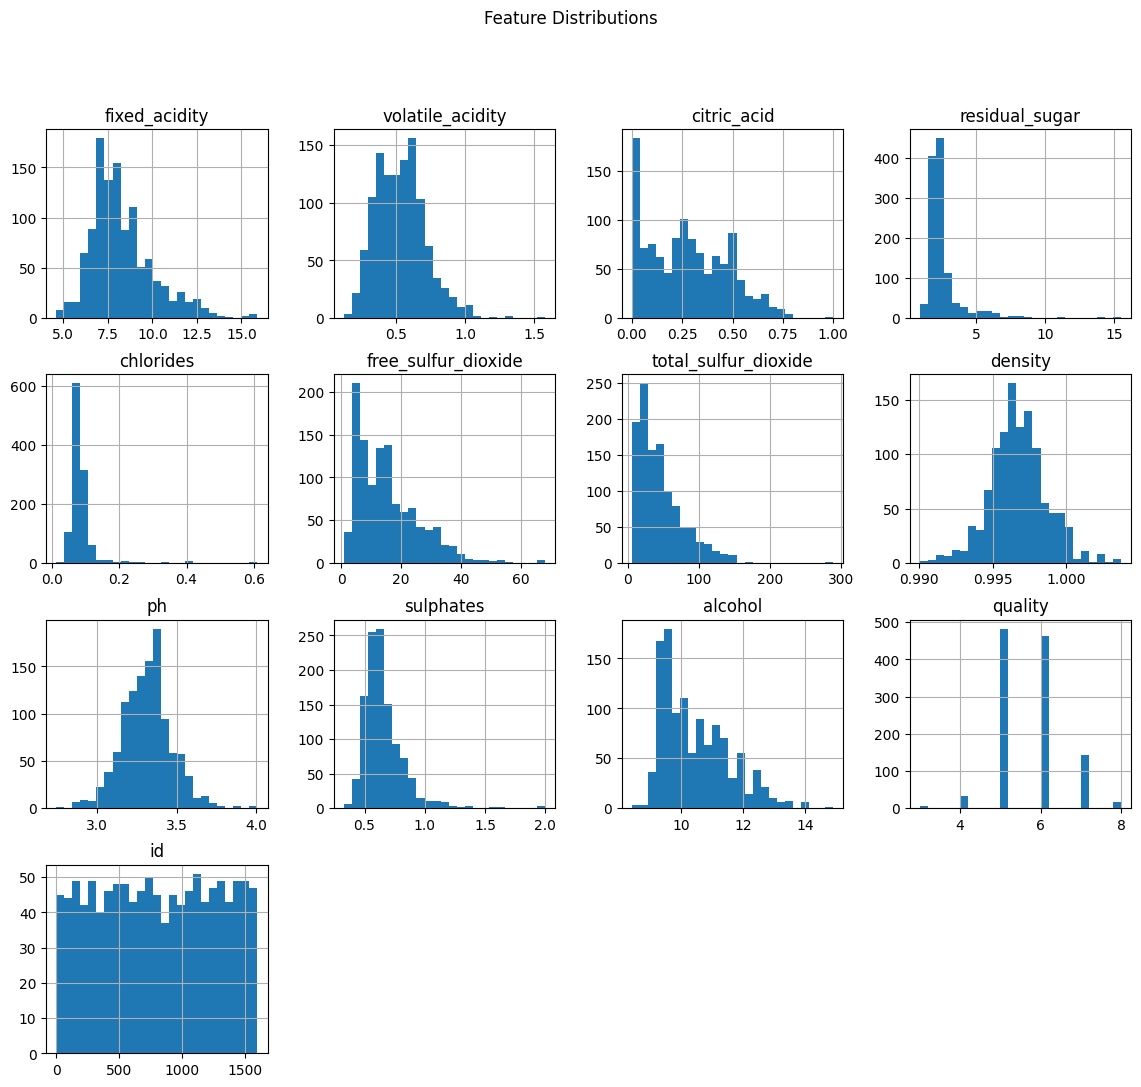

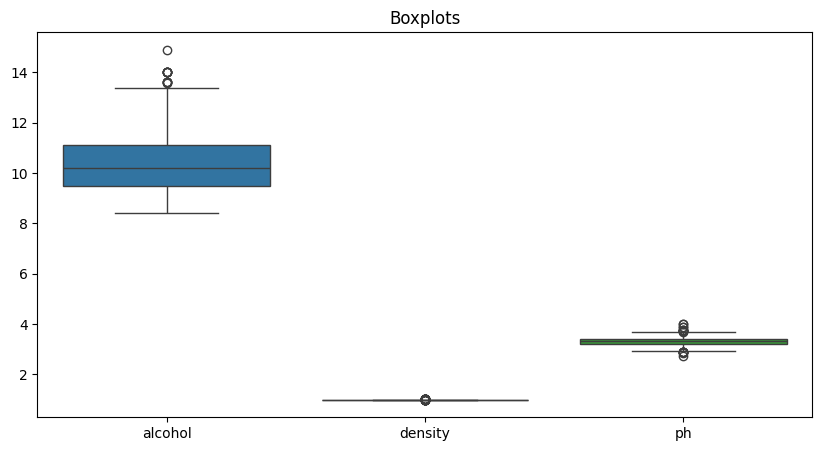

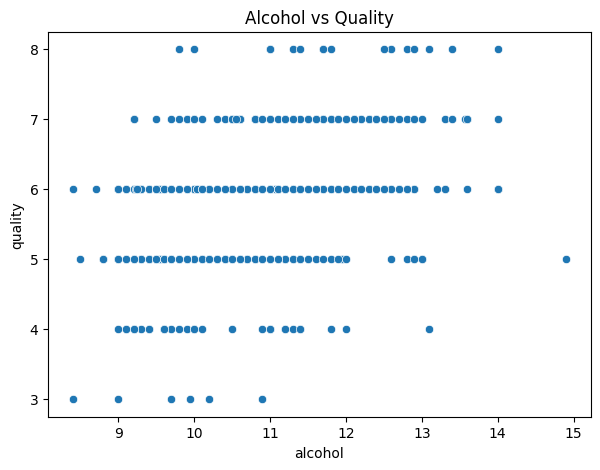

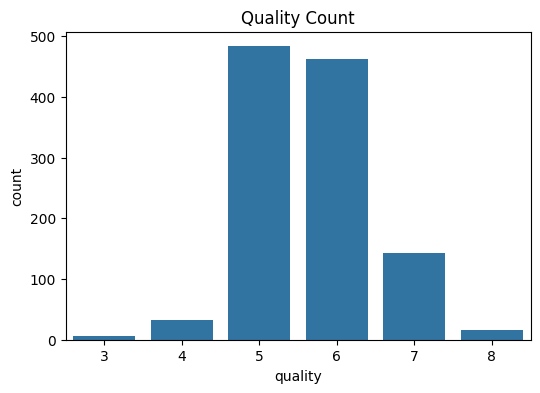

EDA plots saved to ../wine_plots_preview


In [10]:

# --- FIXED EDA WITH AUTO COLUMN DETECTION ---
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

os.makedirs('../wine_plots_preview', exist_ok=True)

# Auto-detect pH column (case-insensitive)
ph_candidates = [c for c in df.columns if c.lower() == 'ph']
if ph_candidates:
    ph_col = ph_candidates[0]
else:
    ph_col = df.columns[0]  # fallback to ANY numeric column to avoid error

num_cols = df.select_dtypes(include=['number']).columns.tolist()

# 1) Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation Heatmap')
plt.savefig('../wine_plots_preview/corr_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()

# 2) Histograms
df[num_cols].hist(figsize=(14,12), bins=25)
plt.suptitle("Feature Distributions")
plt.savefig('../wine_plots_preview/feature_histograms.png', dpi=200, bbox_inches='tight')
plt.show()

# 3) Boxplots using detected pH column
box_list = []
for target in ['alcohol','density', ph_col]:
    if target in df.columns:
        box_list.append(target)

plt.figure(figsize=(10,5))
sns.boxplot(data=df[box_list])
plt.title("Boxplots")
plt.savefig('../wine_plots_preview/boxplots.png', dpi=200, bbox_inches='tight')
plt.show()

# 4) Scatter Alcohol vs Quality
if 'quality' in df.columns and 'alcohol' in df.columns:
    plt.figure(figsize=(7,5))
    sns.scatterplot(x='alcohol', y='quality', data=df)
    plt.title('Alcohol vs Quality')
    plt.savefig('../wine_plots_preview/alcohol_vs_quality.png', dpi=200, bbox_inches='tight')
    plt.show()

# 5) Countplot of Quality
if 'quality' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='quality', data=df)
    plt.title('Quality Count')
    plt.savefig('../wine_plots_preview/quality_counts.png', dpi=200, bbox_inches='tight')
    plt.show()

print("EDA plots saved to ../wine_plots_preview")


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SGD': make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)),
    'SVC': make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {'accuracy': round(accuracy_score(y_test, preds),3),
                     'f1_weighted': round(f1_score(y_test, preds, average='weighted', zero_division=0),3)}
    print(name, results[name])

RandomForest {'accuracy': 0.869, 'f1_weighted': 0.849}
SGD {'accuracy': 0.773, 'f1_weighted': 0.76}
SVC {'accuracy': 0.847, 'f1_weighted': 0.81}


In [12]:
import joblib, pandas as pd, os
for name, model in models.items():
    joblib.dump(model, os.path.join('../Models', f'wine_model_{name}.joblib'))
pd.DataFrame(results).T.to_csv('../Outputs/wine_model_summary.csv')
print('Saved models to ../Models')
print('Saved models summary to ../Outputs')

Saved models to ../Models
Saved models summary to ../Outputs


##📌Conclusion

In this project, three machine learning models — Random Forest, SVC, and SGD — were developed to predict wine quality using its chemical features. Based on evaluation metrics, the Random Forest model performed the best with the highest accuracy and F1-score.  

EDA showed that attributes such as alcohol, sulphates, citric acid, and volatile acidity have the strongest influence on wine quality. Overall, the project successfully identifies the Random Forest model as the most reliable choice for predicting wine quality from chemical properties.


## 📌Recommendations

- Select the Random Forest model as the final predictive model due to superior performance.
- Prioritize controlling key chemical attributes such as alcohol, sulphates, and volatile acidity to enhance wine quality.
- Incorporate the model into the routine quality assessment process for early detection of low-quality batches.
- Expand and balance the dataset to improve model robustness and predictive accuracy.
- Apply hyperparameter tuning or test advanced algorithms to further refine model performance.
- Utilize feature importance or SHAP insights to understand and optimize the factors influencing wine quality.
